## 1. A simulation exercise in regularization framework: sparsity in population coefficients

In [103]:
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.linear_model import LassoCV, Lasso, RidgeCV, Ridge, LinearRegression
from sklearn.model_selection import KFold
import pandas as pd
random.seed(1)

In [77]:
def gen_data(n, p, regime="sparse"):
    # constants chosen to get R^2 of approximately .80
    if regime == "sparse":
        beta = ((1 / np.arange(1, p + 1)) ** 2) * 7
    elif regime == "dense":
        beta = ((np.random.normal(0, 1, p)) * 0.35)
    elif regime == "sparsedense":
        # taking out either results in an R^2 of approximately .69
        beta = (((1 / np.arange(1, p + 1)) ** 2) * 5) + ((np.random.normal(0, 1, p)) * 0.25)

    def true_fn(x):
        return x @ beta

    X = np.random.uniform(-.5, .5, size=(n, p))
    gX = true_fn(X)
    y = gX + np.random.normal(0, 1, size=n)
    Xtest = np.random.uniform(-.5, .5, size=(n, p))
    gXtest = true_fn(Xtest)
    ytest = gXtest + np.random.normal(0, 1, size=n)
    Xpop = np.random.uniform(-.5, .5, size=(100000, p))  # almost population limit
    gXpop = true_fn(Xpop)
    ypop = gXpop + np.random.normal(0, 1, size=100000)  # almost population limit
    return X, y, gX, Xtest, ytest, gXtest, Xpop, ypop, gXpop, beta

## Sparse coefficients

In [78]:
n = 100
p = 400
X, y, gX, Xtest, ytest, gXtest, Xpop, ypop, gXpop, betas = gen_data(n, p, regime="sparse")

In [79]:
print(f"theoretical R^2:, {1 - np.var(ypop - gXpop) / np.var(ypop)}")
print(f"theoretical R^2:, {np.var(gXpop) / np.var(ypop)}")

theoretical R^2:, 0.8147405100234308
theoretical R^2:, 0.813809386452127


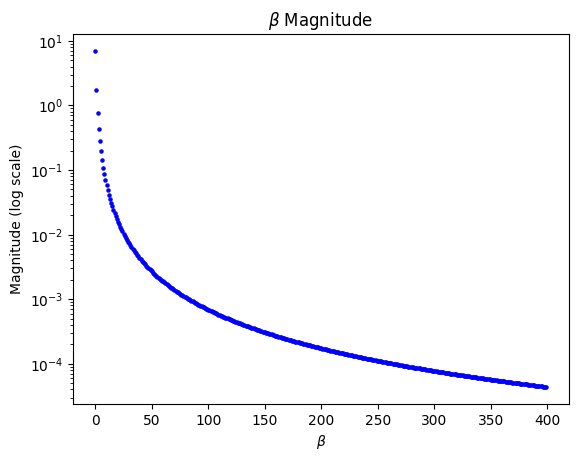

In [80]:
plt.figure()
plt.scatter(range(len(betas)), abs(betas), s=5, color='b')
plt.xlabel(r'$\beta$')
plt.ylabel('Magnitude (log scale)')
plt.yscale('log')
plt.title(r'$\beta$ Magnitude')
plt.show()

In [101]:
model_l1 = LassoCV(alphas=alpha).fit(X,y)
model_l1.alpha_

np.float64(0.09)

In [102]:
# Lasso cross validation from scratch (as stated in lecture 3)

upper_bound = 1
niter = 100
alpha = np.arange(0,upper_bound,upper_bound/niter)
kf = KFold(n_splits=5)

avg_mspe = []

for i in alpha:

    fold_pe = []

    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = Lasso(alpha=i).fit(X_train,y_train)

        predict = model.predict(X_test)

        pe = np.sum((y_test-predict)**2+i*np.sum(abs(model.coef_)))

        fold_pe.append(pe)

    avg_mspe.append(np.mean(np.array(fold_pe)))

alpha[np.where(np.array(avg_mspe)==np.min(np.array(avg_mspe)))]

array([0.07])

In [109]:
model_l2 = RidgeCV().fit(X,y)
model_l2.alpha_

np.float64(10.0)

In [121]:
# Ridge cross validation from scratch (as stated in lecture 3)

upper_bound = 10
niter = 100
alpha = np.arange(0.01,upper_bound,upper_bound/niter)
kf = KFold(n_splits=5)

avg_mspe = []

for i in alpha:

    fold_pe = []

    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = Ridge(alpha=i).fit(X_train,y_train)

        predict = model.predict(X_test)

        pe = np.sum((y_test-predict)**2+i*np.sum((model.coef_)**2))

        fold_pe.append(pe)

    avg_mspe.append(np.mean(np.array(fold_pe)))

alpha[np.where(np.array(avg_mspe)==np.min(np.array(avg_mspe)))]

array([4.51])

## Dense coefficients

In [110]:
n = 100
p = 400
X, y, gX, Xtest, ytest, gXtest, Xpop, ypop, gXpop, betas = gen_data(n, p, regime="dense")

In [111]:
print(f"theoretical R^2:, {1 - np.var(ypop - gXpop) / np.var(ypop)}")
print(f"theoretical R^2:, {np.var(gXpop) / np.var(ypop)}")

theoretical R^2:, 0.8125982476880653
theoretical R^2:, 0.8116167085622936


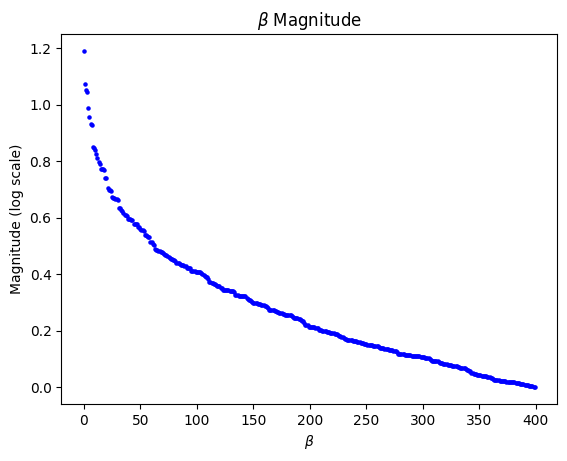

In [112]:
plt.figure()
plt.scatter(range(len(betas)), np.sort(abs(betas))[::-1], s=5, color='b')
plt.xlabel(r'$\beta$')
plt.ylabel('Magnitude (log scale)')
plt.title(r'$\beta$ Magnitude')
plt.show()

## 2. A Simple Case Study using Wage Data from 2015

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, LinearRegression, Ridge
import patsy
import warnings
from sklearn.base import BaseEstimator
import statsmodels.api as sm
warnings.simplefilter('ignore')
np.random.seed(1234)

### Data

We consider data from the U.S. March Supplement of the Current Population Survey (CPS) in 2015.
The preproccessed sample consists of $5150$ never-married individuals.

In [60]:
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/wage2015_subsample_inference.csv"
data = pd.read_csv(file)
data.describe()

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
count,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000
mean,23.410410,2.970787,0.444466,0.023301,0.243883,0.278058,0.317670,0.137087,0.259612,0.296505,0.216117,0.227767,13.760583,3.018925,8.235867,25.118038,5310.737476,11.670874,6629.154951,13.316893
std,21.003016,0.570385,0.496955,0.150872,0.429465,0.448086,0.465616,0.343973,0.438464,0.456761,0.411635,0.419432,10.609465,4.000904,14.488962,53.530225,11874.356080,6.966684,5333.443992,5.701019
min,3.021978,1.105912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,370.000000,2.000000
25%,13.461538,2.599837,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.250000,0.125000,0.062500,1740.000000,5.000000,4880.000000,9.000000
50%,19.230769,2.956512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,1.000000,1.000000,4040.000000,13.000000,7370.000000,14.000000
75%,27.777778,3.324236,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,21.000000,4.410000,9.261000,19.448100,5610.000000,17.000000,8190.000000,18.000000
max,528.845673,6.270697,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,47.000000,22.090000,103.823000,487.968100,100000.000000,22.000000,100000.000000,22.000000


In [61]:
y = np.log(data['wage']).values
Z = data.drop(['wage', 'lwage'], axis=1)
Z.columns

Index(['sex', 'shs', 'hsg', 'scl', 'clg', 'ad', 'mw', 'so', 'we', 'ne', 'exp1',
       'exp2', 'exp3', 'exp4', 'occ', 'occ2', 'ind', 'ind2'],
      dtype='object')

The following figure shows the weekly wage distribution from the US survey data.

(0.0, 3000.0)

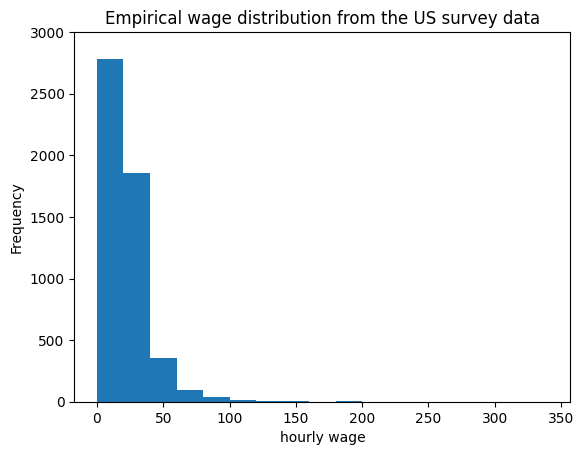

In [62]:
plt.hist(data.wage, bins=np.arange(0, 350, 20))
plt.xlabel('hourly wage')
plt.ylabel('Frequency')
plt.title('Empirical wage distribution from the US survey data')
plt.ylim((0, 3000))

Wages show a high degree of skewness. Hence, wages are transformed in almost all studies by the logarithm.

Due to the skewness of the data, we are considering log wages which leads to the following regression model

$$\log(\operatorname{wage}) = g(Z) + \epsilon.$$

In this notebook, we will evaluate *linear* prediction rules. In later notebooks, we will also utilize nonlinear prediction methods. In linear models, we estimate the prediction rule of the form

$$\hat g(Z) = \hat \beta'X.$$

Again, we generate $X$ in three ways:

1. Basic Model:   $X$ consists of a set of raw regressors (e.g. gender, experience, education indicators, regional indicators).


2. Flexible Model:  $X$ consists of all raw regressors from the basic model plus occupation and industry indicators, transformations (e.g., $\operatorname{exp}^2$ and $\operatorname{exp}^3$) and additional two-way interactions.

3. Extra Flexible Model: $X$ takes the flexible model and takes all pairwise interactions.

To evaluate the out-of-sample performance, we split the data first.

As known from our first lab, the basic model consists of $51$ regressors, and the flexible model has $246$ regressors. Let us fit our models to the training sample using the two different model specifications. We are starting by running a simple ols regression and computing the $R^2$ on the test sample.

### Low dimensional specification (basic)

In [65]:
Zbase = patsy.dmatrix('0 + sex + exp1 + shs + hsg+ scl + clg + mw + so + we + C(occ2) + C(ind2)',
                      Z, return_type='dataframe').values

In [66]:
X_train, X_test, y_train, y_test = train_test_split(Zbase, y, test_size=0.25, random_state=123)

In [68]:
lr_base = LinearRegression().fit(X_train, y_train)

Let's calculate R-squared on the test set

In [69]:
r2_base = 1 - np.mean((y_test - lr_base.predict(X_test))**2) / np.var(y_test)
print(f'{r2_base:.4f}')

0.2853


In fact `sklearn` provides an implementation

In [70]:
print(f'{r2_score(y_test, lr_base.predict(X_test)):.4f}')

0.2853


Since out of sample performance can be vary for different train-test splits, it is more stable to look at average performance across multiple splits, using K-fold cross validation.

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(LinearRegression(), Zbase, y, scoring='r2', cv=cv)
print(f'{np.mean(rsquares):.4f}')

### High-dimensional specification (flexible)

We repeat the same procedure for the flexible model.

In [ ]:
Zflex = patsy.dmatrix('0 + sex + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+C(occ2)+C(ind2)+mw+so+we)',
                      Z, return_type='dataframe').values

In [ ]:
Zflex.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Zflex, y, test_size=0.25, random_state=123)

In [ ]:
lr_flex = LinearRegression().fit(X_train, y_train)

In [ ]:
print(f'{r2_score(y_test, lr_flex.predict(X_test)):.4f}')

### Penalized regressions (flexible model)

We observe that ols regression works better for the basic model with smaller $p/n$ ratio. We proceed by running penalized regressions first for the flexible model, tuned via cross-validation.

First we try a pure `l1` penalty, tuned using cross-validation. For penalized regressions it is important that our features have the same standard deviation, so that we are symmetrically penalizing them

In [71]:
from sklearn.preprocessing import StandardScaler
Zflex = StandardScaler().fit_transform(Zflex)

NameError: name 'Zflex' is not defined

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(LassoCV(cv=cv), Zflex, y, scoring='r2', cv=cv, n_jobs=-1)
print('Flexible model R^2 (Lasso): ', f'{np.mean(rsquares):.4f}')

Then we try a pure `l2` penalty, tuned using cross-validation

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(RidgeCV(cv=cv), Zflex, y, scoring='r2', cv=cv, n_jobs=-1)
print('Flexible model R^2 (Ridge): ', f'{np.mean(rsquares):.4f}')

### Extra high-dimensional specification (extra flexible)

We repeat the same procedure for the extra flexible model.

In [ ]:
Zextra = patsy.dmatrix('0 + sex + (exp1+exp2+exp3+exp4+shs+hsg+scl+clg+C(occ2)+C(ind2)+mw+so+we)**2',
                       Z, return_type='dataframe').values
Zextra.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Zextra, y, test_size=0.25, random_state=123)
lr_extra = LinearRegression().fit(X_train, y_train)
print(f'{r2_score(y_test, lr_extra.predict(X_test)):.4f}')

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(StatsModelsOLS(), Zextra, y, scoring='r2', cv=cv, n_jobs=-1)
print(f'{np.mean(rsquares):.4f}')

#### Penalized regressions (extra flexible model)

Now let's repeat our penalized regression analysis for the extra flexible model. Note this block takes a while!

In [ ]:
Zextra = StandardScaler().fit_transform(Zextra)

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(LassoCV(cv=cv), Zextra, y, scoring='r2', cv=cv, n_jobs=-1)
print('Extra flexible model R^2 (Lasso): ', f'{np.mean(rsquares):.4f}')
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(RidgeCV(cv=cv), Zextra, y, scoring='r2', cv=cv, n_jobs=-1)
print('Extra flexible model R^2 (Ridge): ', f'{np.mean(rsquares):.4f}')